In [9]:
import cv2
import numpy as np
import os

def remove_hair(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a kernel for line detection
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17,17))

    # Use blackhat morphological operation to identify dark regions
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Apply thresholding to create a binary mask of potential hair regions
    _, thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # Use inpainting to fill in the hair regions
    inpaint = cv2.inpaint(image, thresh, 1, cv2.INPAINT_TELEA)

    return inpaint

def process_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                output_path = os.path.join(output_dir, 'nohair_' + file)

                image = cv2.imread(image_path)
                hair_removed = remove_hair(image)

                cv2.imwrite(output_path, hair_removed)

    print(f"Processed images saved in {output_dir}")

# Usage
input_directory = 'data/archive/'
output_directory = 'data/hair_removed'

process_images(input_directory, output_directory)

Processed images saved in data/hair_removed


In [10]:
import cv2
import numpy as np
import os

def watershed_segmentation(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Otsu's method to get a threshold
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal using morphological operations
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply watershed
    markers = cv2.watershed(image, markers)

    # Create mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[markers > 1] = 255

    return mask

def process_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                output_path = os.path.join(output_dir, file.rsplit('.', 1)[0] + '_mask.png')

                image = cv2.imread(image_path)
                mask = watershed_segmentation(image)

                cv2.imwrite(output_path, mask)

    print(f"Processed images saved in {output_dir}")

# Usage
input_directory = 'data/hair_removed/'
output_directory = 'data/masks/'

process_images(input_directory, output_directory)

Processed images saved in data/masks/


In [17]:
import cv2
import numpy as np
import os

def crop_to_roi(image, mask, padding=10):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return image  # Return original image if no contours found

    # Find the largest contour (assuming it's the lesion)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding box of the contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Add padding
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(image.shape[1] - x, w + 2*padding)
    h = min(image.shape[0] - y, h + 2*padding)

    # Crop the image
    cropped = image[y:y+h, x:x+w]

    return cropped

def process_images(image_dir, mask_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # walk through the image directory
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.png')):
                image_path = os.path.join(root, file)
                mask_path = os.path.join(mask_dir, file.replace('.jpg', '_mask.png'))

                if not os.path.exists(mask_path):
                    print(f"Mask not found for {file}")
                    continue

                image = cv2.imread(image_path)
                mask = cv2.imread(mask_path, 0)  # Read as grayscale

                cropped = crop_to_roi(image, mask)

                output_path = os.path.join(output_dir, f"cropped_{file}")
                cv2.imwrite(output_path, cropped)

    print(f"Cropped images saved in {output_dir}")

# Usage
image_directory = 'data/hair_removed/'
mask_directory = 'data/masks/'
output_directory = 'data/cropped/'

process_images(image_directory, mask_directory, output_directory)

Cropped images saved in data/cropped/


In [23]:
import cv2
import numpy as np
import os

def create_masked_image(image, mask):
    # Ensure mask is binary
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Resize mask to match image dimensions if they don't match
    if image.shape[:2] != binary_mask.shape[:2]:
        binary_mask = cv2.resize(binary_mask, (image.shape[1], image.shape[0]))

    # Create a 3-channel mask
    mask_3channel = cv2.merge([binary_mask, binary_mask, binary_mask])

    # Apply mask to image
    masked_image = cv2.bitwise_and(image, mask_3channel)

    return masked_image

def process_images(image_dir, mask_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, dirs, files in os.walk(image_dir):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.png')):
                image_path = os.path.join(root, filename)
                # remove cropped_nohair_ prefix
                mask_filename = filename.replace('nohair_', '').replace('.jpg', '_mask.png')
                mask_path = os.path.join(mask_dir, mask_filename)

                if not os.path.exists(mask_path):
                    print(f"Mask not found for {filename}")
                    continue

                image = cv2.imread(image_path)
                if image is None:
                    print(f"Failed to read image: {filename}")
                    continue

                mask = cv2.imread(mask_path, 0)  # Read as grayscale
                if mask is None:
                    print(f"Failed to read mask: {mask_filename}")
                    continue

                try:
                    masked_image = create_masked_image(image, mask)
                    output_path = os.path.join(output_dir, f"masked_{filename}")
                    cv2.imwrite(output_path, masked_image)
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")

    print(f"Masked images saved in {output_dir}")

# Usage
image_directory = 'data/hair_removed//'
mask_directory = 'data/masks/'
output_directory = 'data/masked_images'

process_images(image_directory, mask_directory, output_directory)

Masked images saved in data/masked_images


IntProgress(value=37, description='Progress:', max=10015)

Label(value='Reviewing image 37 of 10015: masked_nohair_ISIC_0031175.jpg')

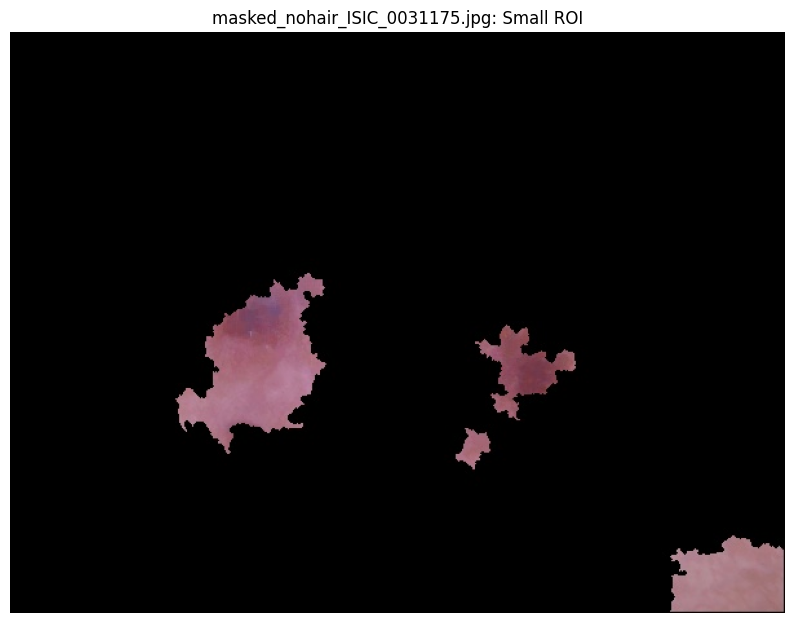

In [2]:
import os
import cv2
import numpy as np
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets

def is_low_contrast(image, threshold=0.45):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    min_val, max_val, _, _ = cv2.minMaxLoc(gray)
    contrast = (max_val - min_val) / 255
    return contrast < threshold

def is_blurry(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var() < threshold

def has_small_roi(image, min_roi_ratio=0.05):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = threshold_otsu(gray)
    binary = gray > thresh
    labeled = label(binary)
    props = regionprops(labeled)

    if not props:
        return True

    largest_region = max(props, key=lambda p: p.area)
    roi_ratio = largest_region.area / (image.shape[0] * image.shape[1])
    return roi_ratio < min_roi_ratio

def check_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return False, "Unable to read image"

    issues = []
    if is_low_contrast(image):
        issues.append("Low contrast")
    if is_blurry(image):
        issues.append("Blurry")
    if has_small_roi(image):
        issues.append("Small ROI")

    return len(issues) == 0, ", ".join(issues) if issues else "OK"

def review_images(image_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]
    total_images = len(image_files)

    keep_button = widgets.Button(description="Keep")
    remove_button = widgets.Button(description="Remove")
    progress = widgets.IntProgress(value=0, min=0, max=total_images, description='Progress:')
    status_label = widgets.Label(value="")

    display(widgets.HBox([keep_button, remove_button]))
    display(progress)
    display(status_label)

    current_index = [0]

    def display_image(index):
        filename = image_files[index]
        image_path = os.path.join(image_dir, filename)
        is_good, message = check_image(image_path)

        image = cv2.imread(image_path)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"{filename}: {message}")
        plt.axis('off')
        plt.show()

        status_label.value = f"Reviewing image {index + 1} of {total_images}: {filename}"
        progress.value = index + 1

        return is_good, message, image_path

    def process_image(index):
        if index >= total_images:
            clear_output(wait=True)
            display(widgets.HTML("<h3>Review complete!</h3>"))
            return

        is_good, message, image_path = display_image(index)

        if is_good:
            # Automatically keep good images
            keep_image(image_path)
            process_image(index + 1)
        else:
            # For problematic images, ask for user input
            clear_output(wait=True)
            display(widgets.HBox([keep_button, remove_button]))
            display(progress)
            display(status_label)
            display_image(index)

            current_index[0] = index

    def keep_image(image_path):
        filename = os.path.basename(image_path)
        image = cv2.imread(image_path)
        cv2.imwrite(os.path.join(output_dir, filename), image)
        print(f"Kept {filename}")

    def on_keep(b):
        keep_image(os.path.join(image_dir, image_files[current_index[0]]))
        process_image(current_index[0] + 1)

    def on_remove(b):
        filename = image_files[current_index[0]]
        print(f"Removed {filename}")
        process_image(current_index[0] + 1)

    keep_button.on_click(on_keep)
    remove_button.on_click(on_remove)

    process_image(0)

# Usage
image_directory = 'data/masked_images/'
output_directory = 'data/cleaned_images'

review_images(image_directory, output_directory)